# Short Notebook 2

Group members for group "Negative Power Inc.2 (Group 14):
- Jørgen Bakken (508173)
- Ola Rasmussen (545564)
- Isak Ytrøy (506533)

The data is stored in a folder called "Data", and the three datasets are then stored in folders "A", "B", and "C" accordingly.

The main packages used are numpy, pandas, matplotlib, seaborn, and the regression package is PyCaret. PyCaret have been tested on python version 3.10.13, with installation "pip install pycaret[full]".

The model used in this notebook is a blend between CatBoost and LightGBM, for which PyCaret has a built in blend function. The blend was weighted 50/50. This model removes all the features that have a feature importance of 0.5 or less.

A RTX4070 laptop gpu was used for training. The code assumes that a gpu is present. This is due to better results and run time when training a model.

The code will export 10 csv files that contains all the run predictions. It will then import those files, take the mean value of them, and then export the final prediction. This is due to slightly different results when using parallell computing (GPU), thus reducing the variance. If a gpu hadnt been used, the code would only have needed to be run once, and it would take much longer (10+ hours) to run.

## Setup packages

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.regression import *
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, HTML

pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 500)

%matplotlib inline
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use("seaborn-v0_8-darkgrid")

sns.set(rc={"figure.dpi":200, 'savefig.dpi':200 , 'figure.figsize': (10, 5)})
sns.set_context('notebook')
sns.set_style("ticks")
sns.set_style('darkgrid')

## Pre-processing of data

In [62]:
# ADD TIME FEATURES
def add_time_features(df, time_column):
    
    df[time_column] = pd.to_datetime(df[time_column])  # Make sure the time column is in datetime format
    
    # Extract various time features
    #df['hour'] = df[time_column].dt.hour
    df['day_of_week'] = df[time_column].dt.dayofweek
    df['month'] = df[time_column].dt.month
    df['day_of_year'] = df[time_column].dt.dayofyear
    df['week_of_year'] = df[time_column].dt.isocalendar().week 
    df['year'] = df[time_column].dt.year

    df['sin_hour'] = np.sin(2*np.pi * df[time_column].dt.hour/24.)
    df['cos_hour'] = np.cos(2*np.pi * df[time_column].dt.hour/24.)
    
    return df
def add_interactions(df): 
    df['sun_elev_cloud_cover_interaction'] = df['sun_elevation:d'] * df['total_cloud_cover:p']

    df['radiation_interaction'] = df['clear_sky_rad:W'] * df['diffuse_rad:W'] * df['direct_rad:W']

    df['atmospheric_interaction'] = df['air_density_2m:kgm3'] * df['msl_pressure:hPa']

    df['temp_humidity_interaction'] = df['dew_point_2m:K'] * df['t_1000hPa:K']

    df['snow_radiation_interaction'] = df['fresh_snow_1h:cm'] * df['clear_sky_rad:W']  # Replace 'clear_sky_rad:W' with 'albedo' if available

    return df
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd

def add_polynomial_features(df, feature_list, degree=2):
    """
    Adds polynomial features for specified features in a DataFrame.

    Parameters:
    - df: pandas.DataFrame - The original DataFrame.
    - feature_list: list - A list of column names to create polynomial features for.
    - degree: int - The degree of the polynomial features to create.

    Returns:
    - df: pandas.DataFrame - The DataFrame with added polynomial features.
    """

    # Initialize the PolynomialFeatures transformer
    poly_transformer = PolynomialFeatures(degree=degree, include_bias=False)

    for feature in feature_list:
        # Check if the feature exists in the dataframe to avoid KeyError
        if feature in df.columns:
            # Reshape the feature column to a 2D array for PolynomialFeatures
            feature_data = df[[feature]].values
            
            # Create polynomial features for the selected feature
            feature_poly = poly_transformer.fit_transform(feature_data)
            
            # Generate new feature names
            feature_names = [f"{feature}^{i}" for i in range(1, degree + 1)]
            
            # Convert the output array to a DataFrame with new feature names
            feature_poly_df = pd.DataFrame(feature_poly, columns=feature_names)
            
            # Concatenate the new polynomial features to the original DataFrame
            df = pd.concat([df, feature_poly_df.iloc[:, 1:]], axis=1)  # Skip the original feature column
            
    return df

def add_rolling_average(df, window_size, fill_method='ffill'):
    """
    Adds rolling average columns to the dataframe based on the specified window size.
    Args:
    - df: The input dataframe.
    - window_size: The number of periods to consider for calculating the rolling average.
    
    Returns:
    - df with new columns for the rolling averages of selected features.
    """
    rolling_features = ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'fresh_snow_12h:cm', 'fresh_snow_1h:cm',
       'fresh_snow_24h:cm', 'fresh_snow_3h:cm', 'fresh_snow_6h:cm',
       'is_in_shadow:idx', 'msl_pressure:hPa', 'precip_5min:mm',
       'pressure_100m:hPa', 'pressure_50m:hPa',
       'prob_rime:p', 'relative_humidity_1000hPa:p',
       'sfc_pressure:hPa', 'snow_depth:cm',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms']
    for feature in rolling_features:
        rolling_name = f'{feature}_rolling_avg_{window_size}'
        df[rolling_name] = df[feature].rolling(window=window_size, min_periods=1, center=True).mean()

        # Handle NaN values at the edges
        if fill_method == 'ffill':
            df[rolling_name].fillna(method='ffill', inplace=True)
        elif fill_method == 'bfill':
            df[rolling_name].fillna(method='bfill', inplace=True)
    return df

def plot_targets(targets, start_date, end_date):
    # Slice the dataframe based on the provided start and end dates
    targets_subset = targets[(targets['time'] >= start_date) & (targets['time'] <= end_date)]

    # Plotting
    plt.figure(figsize=(15, 6))
    plt.plot(targets_subset['time'], targets_subset['pv_measurement'], label='PV Measurement', color='blue')
    plt.xlabel('Time')
    plt.ylabel('PV Measurement')
    plt.title('PV Measurement Over Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
def make_categorical(df, feature_list):
    for feature in feature_list:
        df[feature] = df[feature].astype('category')
    return df
def add_time_delta(observed, estimated, test):
    estimated['time_delta'] = (estimated['date_forecast'] - estimated['date_forecast'].dt.normalize()).dt.total_seconds() / 3600
    observed['time_delta'] = 0
    test['time_delta'] = (test['date_forecast'] - test['date_forecast'].dt.normalize()).dt.total_seconds() / 3600
    return observed, estimated, test

def add_is_estimated(observed, estimated, test):
    estimated['is_estimated'] = 1
    observed['is_estimated'] = 0
    test['is_estimated'] = 1
    return observed, estimated, test

def process_data(observed, estimated, test):
    observed, estimated, test = add_time_delta(observed, estimated, test)
    observed, estimated, test = add_is_estimated(observed, estimated, test)
    train = pd.concat([observed, estimated], axis=0).sort_values(by='date_forecast')
    return train, test

def set_date_time(targets, observed, estimated, test):
    targets['time'] = pd.to_datetime(targets['time'])
    observed['date_forecast'] = pd.to_datetime(observed['date_forecast'])
    estimated['date_forecast'] = pd.to_datetime(estimated['date_forecast'])
    test['date_forecast'] = pd.to_datetime(test['date_forecast'])
    return targets, observed, estimated, test

def resample_data(observed, estimated, test):
    observed_resampled = observed.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    test_resampled = test.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    return observed_resampled, estimated_resampled, test_resampled

def extract_is_day_feature(test):
    is_day_feature = test[['date_forecast', 'is_day:idx']]
    is_day_feature['is_day:idx'] = is_day_feature['is_day:idx'].replace({0.25: 1, 0.5: 1, 0.75: 1, 1: 1, 0: 0})
    return is_day_feature

def extract_time_limit(targets):
    first_date = targets['time'].min()
    last_date = targets['time'].max()
    return first_date, last_date

def drop_features(train, test):
    train = train.drop(columns=['time', 'date_forecast', 'pv_measurement'])
    test = test.drop(columns=['date_forecast'])
    return train, test

def add_several_rolling_average(train, test, lst_of_window_sizes):
    for size in lst_of_window_sizes: 
        train = add_rolling_average(train, window_size=size)
        test = add_rolling_average(test, window_size=size)
    return train, test
def calculate_incidence_angles(df, latitude = 60):
    # Define a function to calculate the angle of incidence for a given row
    def angle_of_incidence(row, tilt_angle_rad, panel_azimuth_rad):
        sun_elevation_rad = np.radians(row['sun_elevation:d'])
        sun_azimuth_rad = np.radians(row['sun_azimuth:d'])
        cos_theta = (
            np.sin(sun_elevation_rad) * np.sin(tilt_angle_rad) +
            np.cos(sun_elevation_rad) * np.cos(tilt_angle_rad) * np.cos(sun_azimuth_rad - panel_azimuth_rad)
        )
        cos_theta = np.clip(cos_theta, -1, 1)  # Ensure cos_theta is within valid range
        return np.degrees(np.arccos(cos_theta))
    
    # Calculate the tilt angle and panel azimuth assuming Norway is in the northern hemisphere
    tilt_angle_rad = np.radians(latitude)
    panel_azimuth_rad = 0  # True south

    # Apply the angle_of_incidence function to each row
    df['angle_of_incidence'] = df.apply(angle_of_incidence, axis=1, tilt_angle_rad=tilt_angle_rad, panel_azimuth_rad=panel_azimuth_rad)
    
    return df
def add_wind_features(train, test):
    for df in [train, test]:
        # Horizontal wind speed magnitude at 10 meters
        df['wind_speed_10m_vector_magnitude:ms'] = np.sqrt(df['wind_speed_u_10m:ms']**2 + df['wind_speed_v_10m:ms']**2)

        # Wind direction at 10 meters
        df['wind_direction_10m:degrees'] = np.degrees(np.arctan2(df['wind_speed_v_10m:ms'], df['wind_speed_u_10m:ms']))

        # Temperature-adjusted wind speed at 10 meters
        df['temp_adjusted_wind_speed_10m:ms'] = df['wind_speed_10m:ms'] * (df['t_1000hPa:K'] / 273.15)

        # Vertical wind shear between surface and 1000 hPa
        # Note: this requires careful interpretation as mentioned earlier
        df['wind_shear_1000hPa_10m:ms'] = df['wind_speed_w_1000hPa:ms'] - df['wind_speed_10m:ms']

        # Wind energy density at 10 meters
        df['wind_energy_density_10m:Wm2'] = 0.5 * 1.225 * (df['wind_speed_10m:ms']**3)  # Using 1.225 kg/m3 as air density at sea level

    return train, test
def remove_constant_blocks(df):
    '''
    Remove constant blocks from the dataframe, i.e. where the value in pv_measurement is constant
    Ex: 0,0,1 -> 0,1
    '''
    df['diff'] = df['pv_measurement'].diff().fillna(0)
    df['constant'] = (df['diff'] == 0).astype(int)
    df['block'] = (df['constant'].diff() != 0).astype(int).cumsum()
    df['block_size'] = df.groupby('block')['constant'].transform('sum') # This gets the size per block

    # Keep the first occurrence by ensuring the block size is greater than 1 and that it's a constant value.
    df = df[~((df['block_size'] >= 1) & (df['pv_measurement'] != 0))]

    # Drop the helper columns
    df.drop(['diff', 'constant', 'block', 'block_size'], axis=1, inplace=True)
    
    return df

# def remove_nonzero_constant_blocks(df, column='pv_measurement'):
#     '''
#     Remove constant blocks from the dataframe where the value in the specified column is constant and non-zero.
#     Ex: 0,0,1,1,1 -> 0,0
#         2,2,0,0,1 -> 0,0,1
#     '''
#     # Calculate the difference between consecutive rows and identify constant blocks
#     df['diff'] = df[column].diff().fillna(0)
#     df['constant'] = (df['diff'] == 0).astype(int)
#     df['block'] = (df['constant'].diff() != 0).astype(int).cumsum()
    
#     # Determine the value of each block and its size
#     df['block_value'] = df.groupby('block')[column].transform('first') # The value of the block
#     df['block_size'] = df.groupby('block')['constant'].transform('sum') # This gets the size per block
    
#     # We only want to keep the block if its size is 1 (non-constant) or if the constant value is 0
#     # This is done by checking if the block size is 1 or if the block value is 0.
#     df = df[(df['block_size'] == 1) | (df['block_value'] == 0)]
    
#     # Drop the helper columns
#     df.drop(['diff', 'constant', 'block', 'block_value', 'block_size'], axis=1, inplace=True)
    
#     return df
def preprocessing(targets, observed, estimated, test):
    targets, observed, estimated, test = set_date_time(targets, observed, estimated, test)
    
    observed, estimated, test = resample_data(observed, estimated, test)

    is_day_feature = extract_is_day_feature(test)

    first_date, last_date = extract_time_limit(targets)
    start_date, end_date = '2017-07-01', '2024-08-30'  
   
    
    train, test = process_data(observed, estimated, test)

    train, test = add_several_rolling_average(train, test, lst_of_window_sizes = [3, 5, 7])

    merged_data = pd.merge(targets, train, how='inner', left_on='time', right_on='date_forecast')

    # Remove constant blocks from the data
    train = remove_constant_blocks(merged_data)

    ###### This one should be double checked ########
    # Remove rows where pv_measurement is 0
    train = train[merged_data['pv_measurement'] != 0]

    # Add the time-based features
    train = add_time_features(train, 'time')  
    test = add_time_features(test, 'date_forecast') 

    targets = train[['time', 'pv_measurement']]
    
    plot_targets(targets, start_date, end_date)

    train, test = drop_features(train, test)

    # train = calculate_incidence_angles(train)
    # test = calculate_incidence_angles(test)

    # train, test = add_wind_features(train, test)

    return train, test, is_day_feature, targets

## Training model and exporting predictions

In [63]:
train_A = pd.read_parquet(f'Data/A/train_targets.parquet').fillna(0)
train_B = pd.read_parquet(f'Data/B/train_targets.parquet').fillna(0)
train_C = pd.read_parquet(f'Data/C/train_targets.parquet').fillna(0)

X_train_estimated_A = pd.read_parquet(f'Data/A/X_train_estimated.parquet')
X_train_estimated_B = pd.read_parquet(f'Data/B/X_train_estimated.parquet')
X_train_estimated_C = pd.read_parquet(f'Data/C/X_train_estimated.parquet')

X_train_observed_A = pd.read_parquet(f'Data/A/X_train_observed.parquet')
X_train_observed_B = pd.read_parquet(f'Data/B/X_train_observed.parquet')
X_train_observed_C = pd.read_parquet(f'Data/C/X_train_observed.parquet')

X_test_estimated_A = pd.read_parquet(f'Data/A/X_test_estimated.parquet')
X_test_estimated_B = pd.read_parquet(f'Data/B/X_test_estimated.parquet')
X_test_estimated_C = pd.read_parquet(f'Data/C/X_test_estimated.parquet')

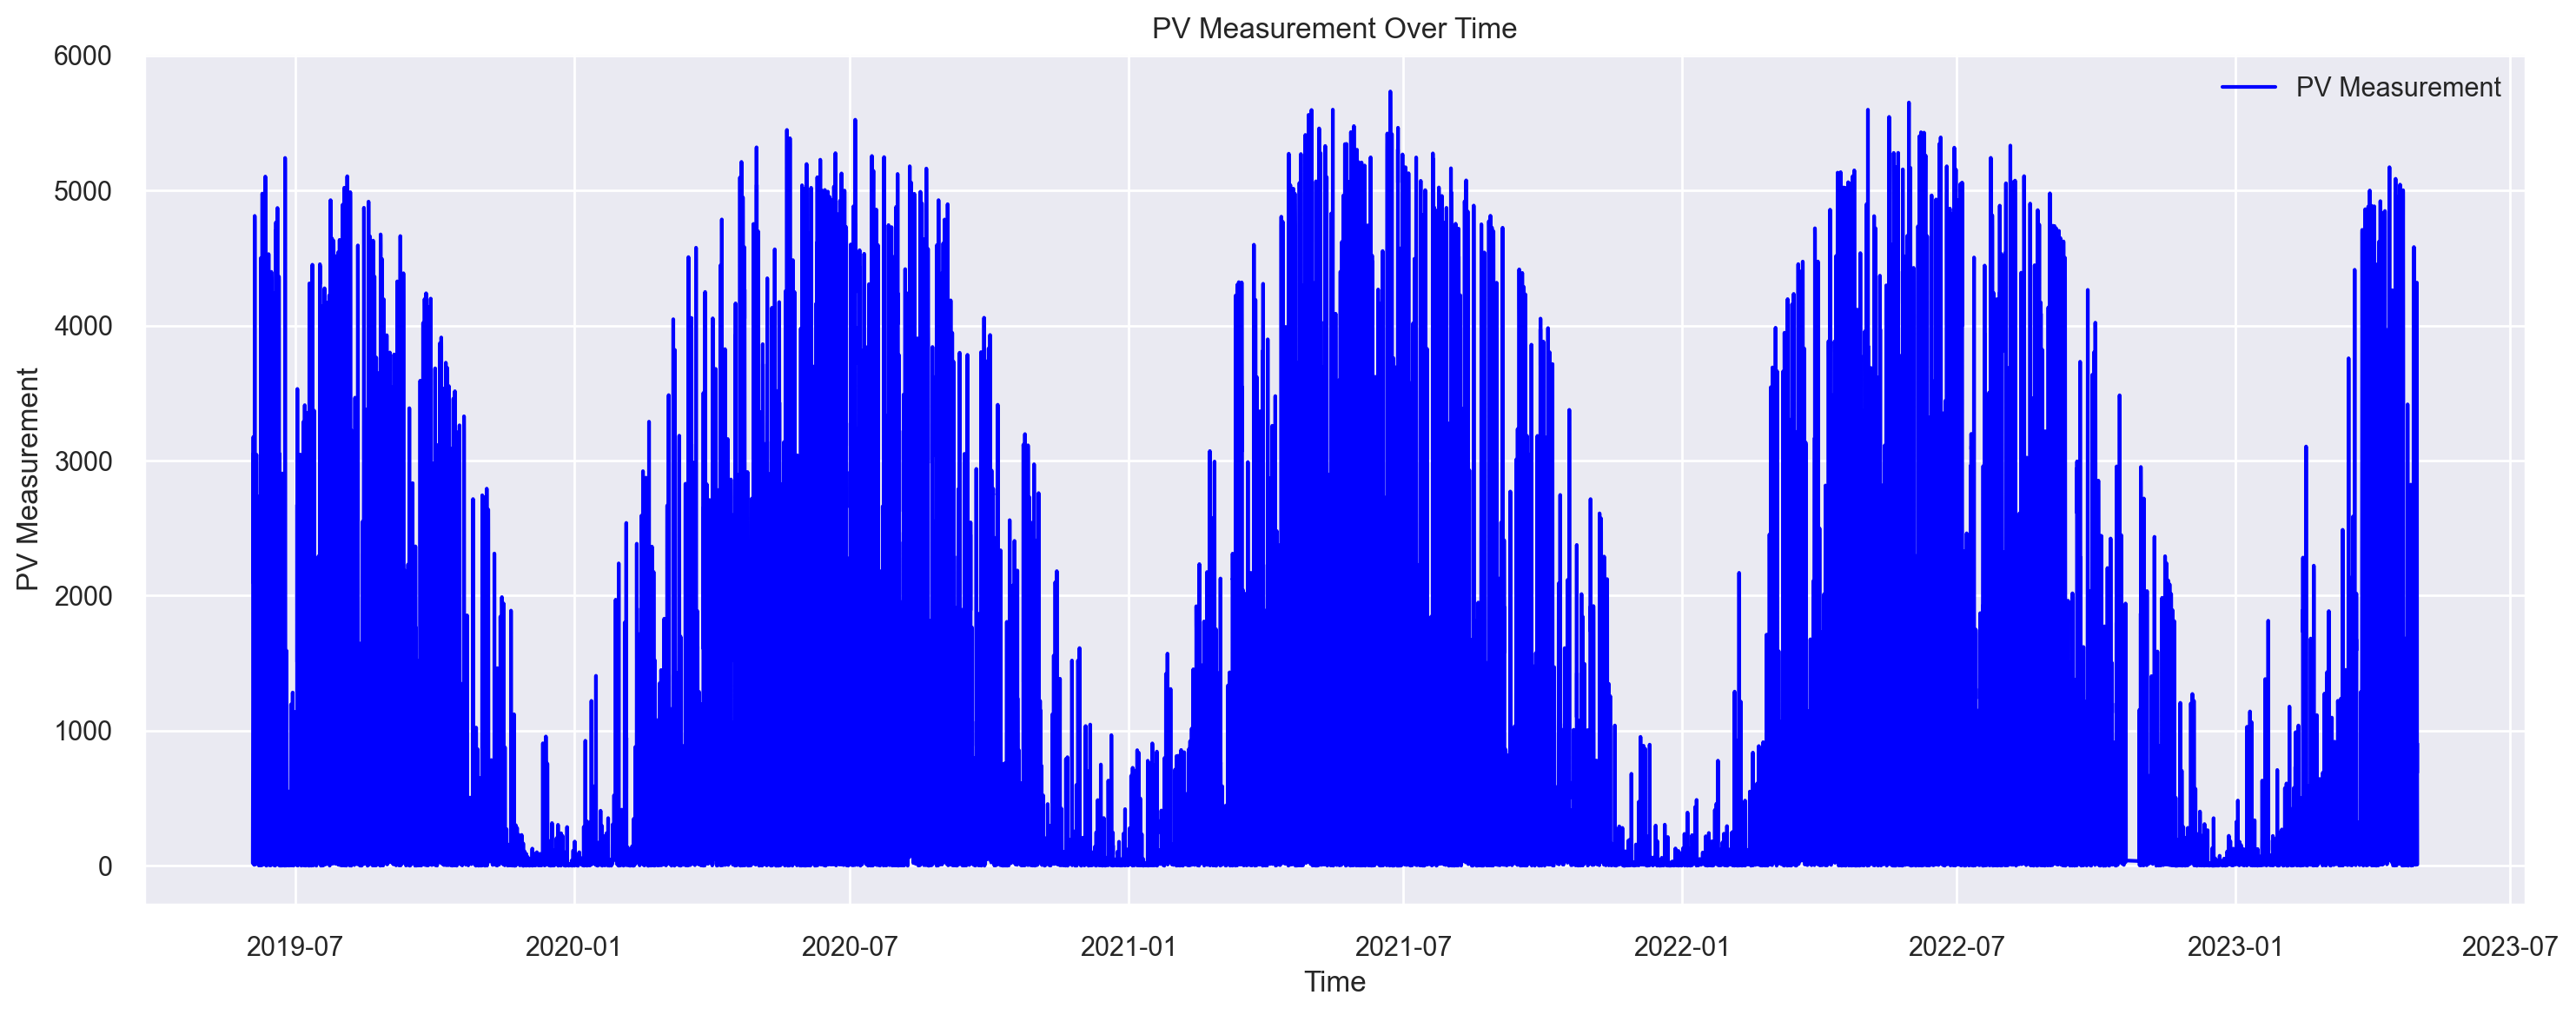

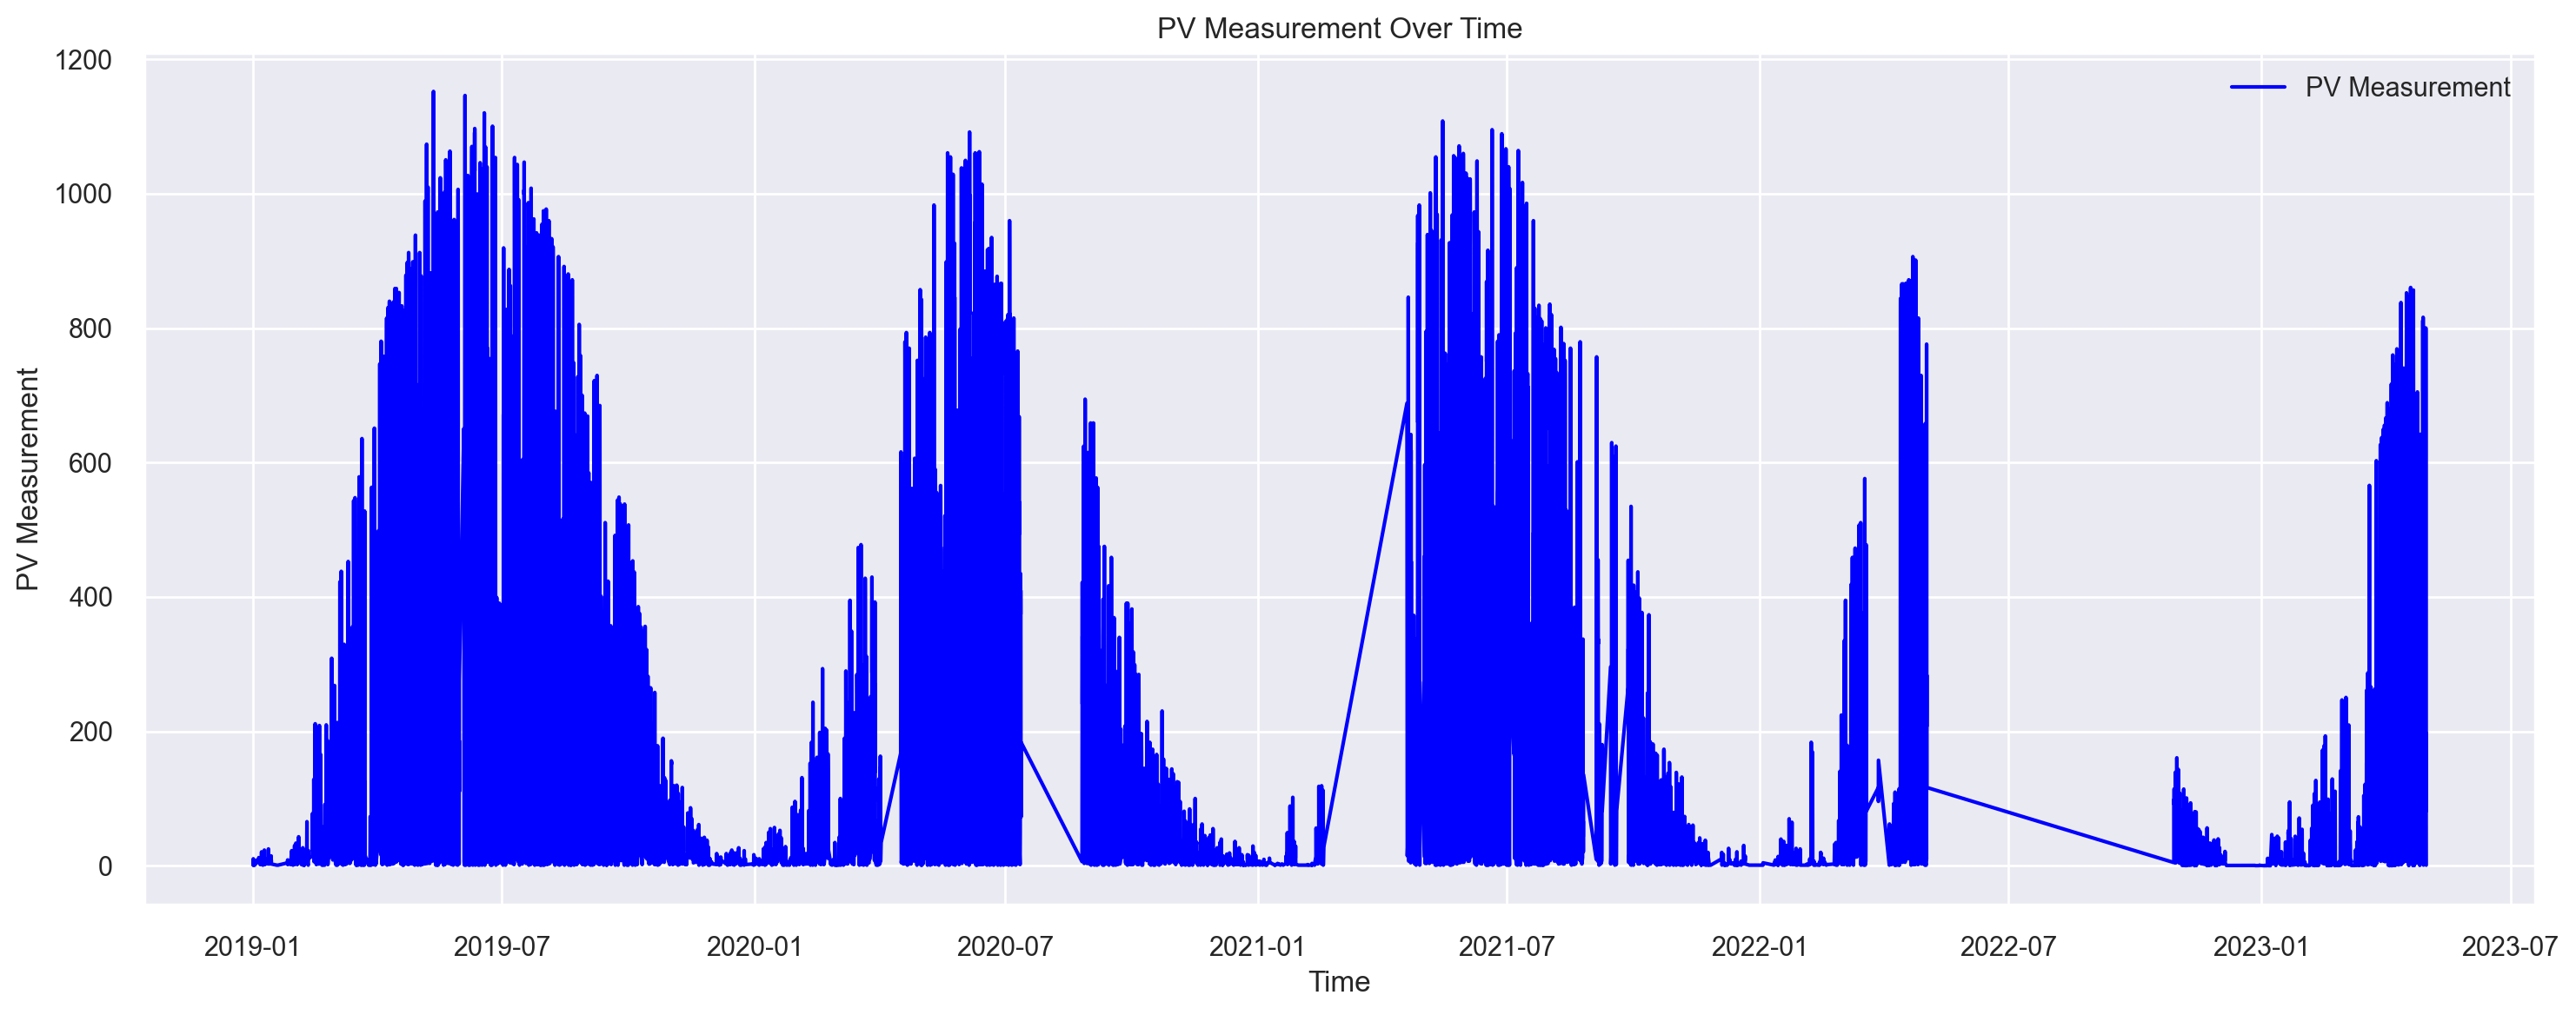

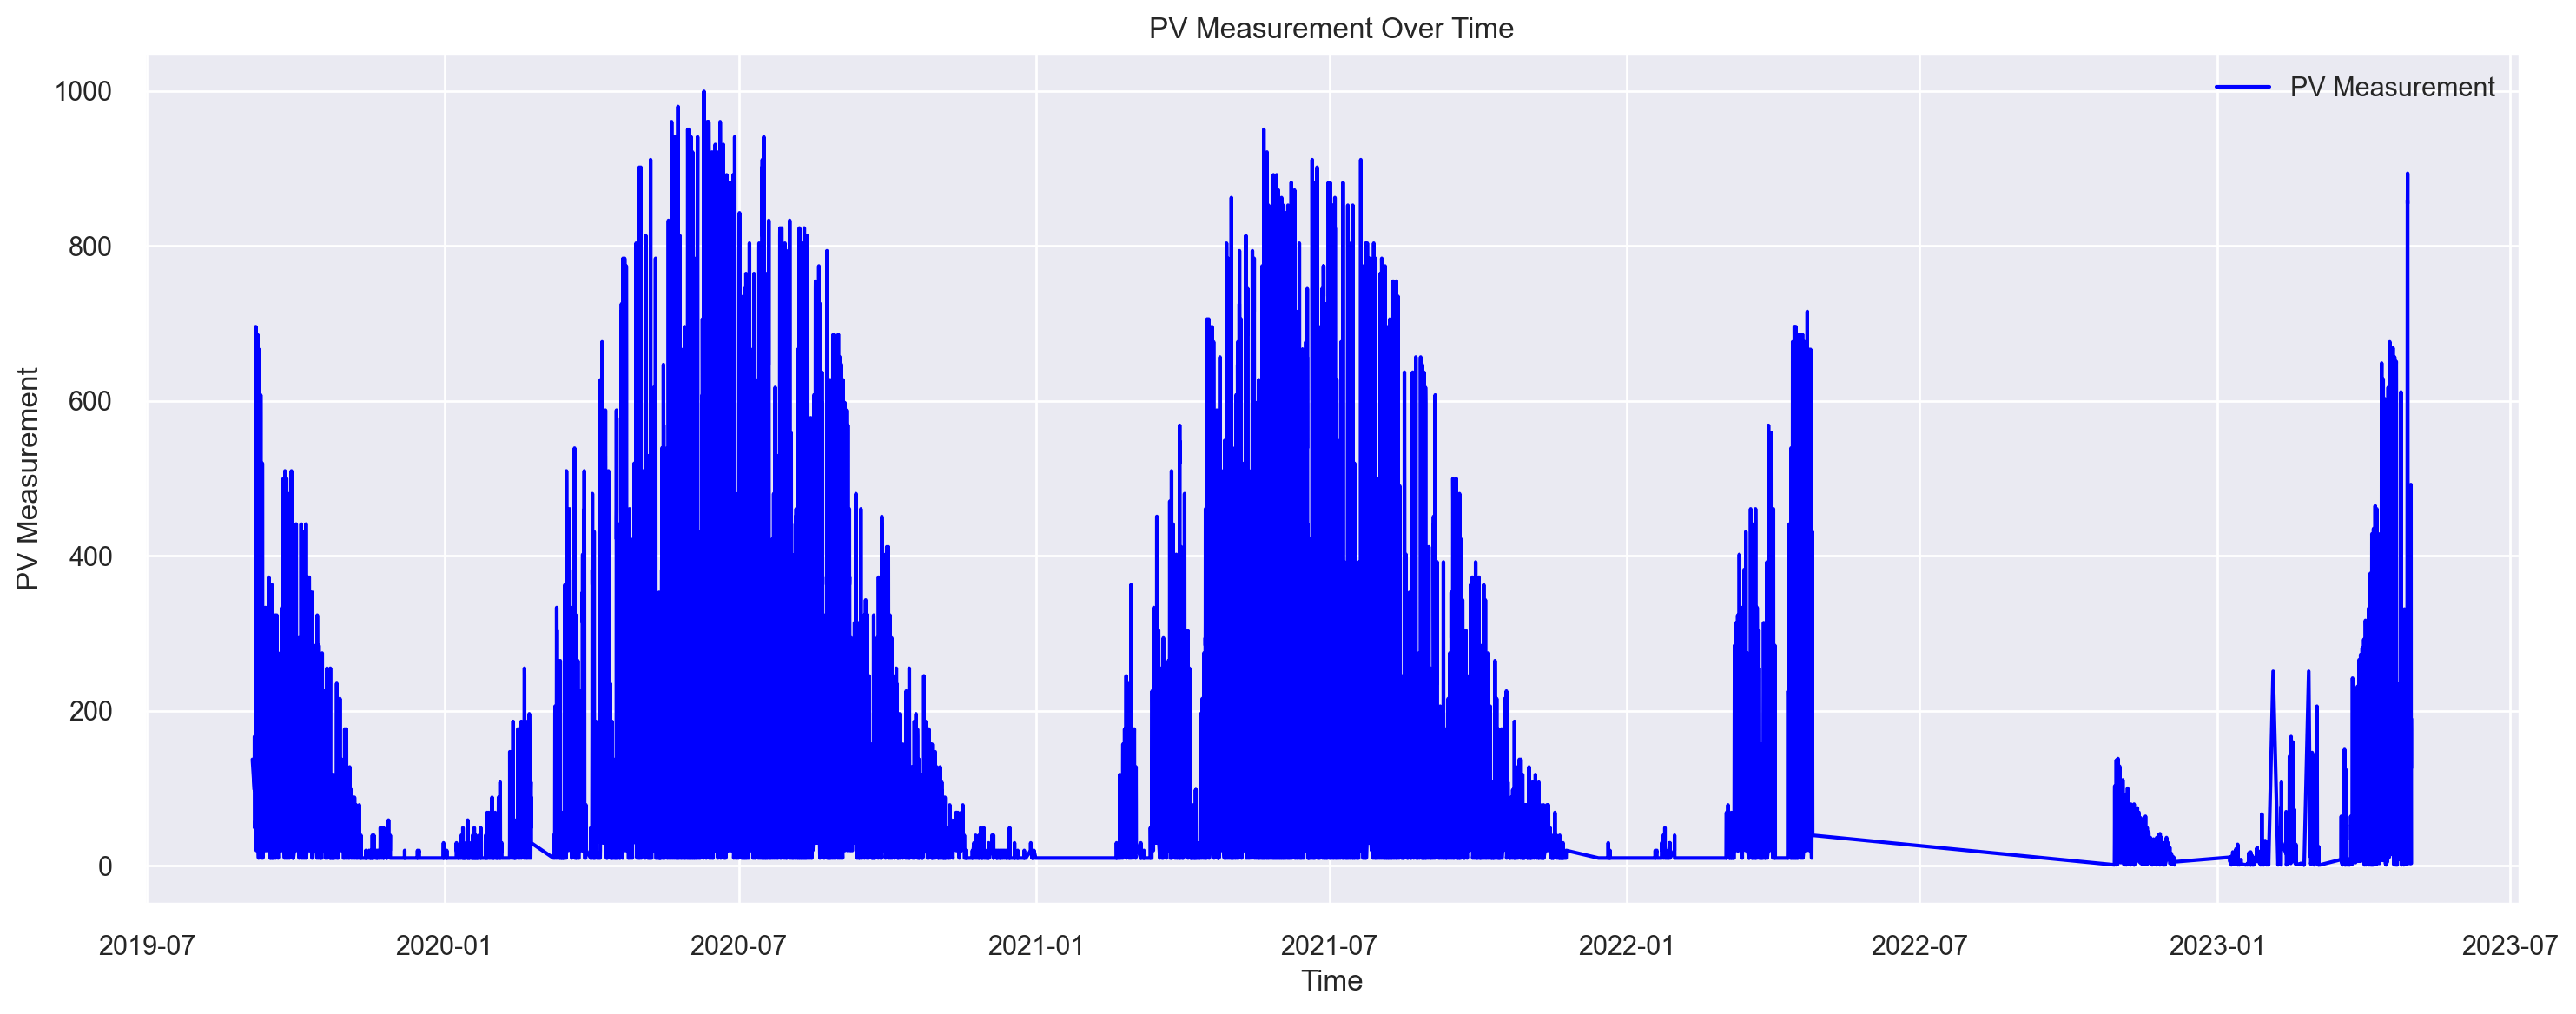

In [64]:
X_train_A, X_test_A, is_day_feature_A, targets_A = preprocessing(train_A, X_train_observed_A, X_train_estimated_A, X_test_estimated_A)
y_train_A = targets_A

# Ensure X and y have the same length
min_length = min(len(X_train_A), len(y_train_A))
X_train_A, y_train_A = X_train_A.iloc[:min_length], y_train_A[:min_length]

data_A = X_train_A.copy()
data_A.columns = data_A.columns.str.replace('[^\w\s]', '')

X_test_A.columns = X_test_A.columns.str.replace('[^\w\s]', '')

data_A['target'] = y_train_A['pv_measurement']

X_train_B, X_test_B, is_day_feature_B, targets_B = preprocessing(train_B, X_train_observed_B, X_train_estimated_B, X_test_estimated_B)
y_train_B = targets_B

# Ensure X and y have the same length
min_length = min(len(X_train_B), len(y_train_B))
X_train_B, y_train_B = X_train_B.iloc[:min_length], y_train_B[:min_length]

data_B = X_train_B.copy()
data_B.columns = data_B.columns.str.replace('[^\w\s]', '')

X_test_B.columns = X_test_B.columns.str.replace('[^\w\s]', '')

data_B['target'] = y_train_B['pv_measurement']

X_train_C, X_test_C, is_day_feature_C, targets_C = preprocessing(train_C, X_train_observed_C, X_train_estimated_C, X_test_estimated_C)
y_train_C = targets_C

# Ensure X and y have the same length
min_length = min(len(X_train_C), len(y_train_C))
X_train_C, y_train_C = X_train_C.iloc[:min_length], y_train_C[:min_length]

data_C = X_train_C.copy()
data_C.columns = data_C.columns.str.replace('[^\w\s]', '')

X_test_C.columns = X_test_C.columns.str.replace('[^\w\s]', '')

data_C['target'] = y_train_C['pv_measurement']

In [74]:
exp_reg_A = RegressionExperiment()
exp_reg_A.setup(
    data = data_A,
    session_id = 123,
    target = 'target',
    categorical_features = ['dew_or_rimeidx', 'is_in_shadowidx', 'is_estimated'],
    experiment_name = 'exp_reg_A',
    use_gpu = True,
)

cat_A = exp_reg_A.create_model('catboost')
lgbm_A = exp_reg_A.create_model('lightgbm')

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are n

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Regression
3,Original data shape,"(18036, 163)"
4,Transformed data shape,"(18036, 175)"
5,Transformed train set shape,"(12625, 175)"
6,Transformed test set shape,"(5411, 175)"
7,Ordinal features,1
8,Numeric features,159
9,Categorical features,3


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are n

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,327.9100,257299.8997,507.2474,0.8619,0.9488,5.8485
1,302.4502,237611.7129,487.4543,0.8683,0.8459,2.6624
2,313.5585,263289.2218,513.1172,0.8544,0.9177,3.4624
3,310.5577,250875.7149,500.8749,0.8608,0.8547,2.6485
4,343.8754,293471.4216,541.7300,0.8431,0.8889,2.9109
5,336.5667,291336.8281,539.7563,0.8482,0.8736,3.5203
6,303.1430,248692.0926,498.6904,0.8667,0.9152,3.2992
7,327.1078,283065.5222,532.0390,0.8621,0.8790,2.5004
8,317.7329,268038.8374,517.7247,0.8549,0.8839,2.8594


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,328.1722,258631.7488,508.5585,0.8612,0.8701,3.8417
1,307.7550,247697.7343,497.6924,0.8627,0.8203,2.4621
2,316.8700,273843.3965,523.3005,0.8485,0.8794,3.2377
3,313.1952,256574.4864,506.5318,0.8576,0.8174,2.3817
4,336.3953,283873.4302,532.7977,0.8482,0.8395,2.5175
5,334.4475,292272.8105,540.6226,0.8477,0.8468,2.5024
6,311.5189,256032.6730,505.9967,0.8627,0.8729,3.0405
7,327.8205,282637.2068,531.6363,0.8624,0.7982,2.1999
8,323.5565,272990.3686,522.4848,0.8522,0.8621,2.5457


In [97]:
limit = .01

model_catboost_feature_importance_A = pd.DataFrame(cat_A.feature_importances_, index=cat_A.feature_names_, columns = ["Importance"])
model_catboost_feature_importance_A.sort_values(by="Importance", ascending=False, inplace=True)
model_catboost_feature_importance_A = model_catboost_feature_importance_A/(model_catboost_feature_importance_A.max())
model_catboost_feature_not_importance_names_A = model_catboost_feature_importance_A[model_catboost_feature_importance_A["Importance"] < limit].index.tolist()
print(f"Cat: {len(model_catboost_feature_not_importance_names_A)}")

model_lightgbm_feature_importance_A = pd.DataFrame(lgbm_A.feature_importances_, index=lgbm_A.feature_name_, columns = ["Importance"])
model_lightgbm_feature_importance_A.sort_values(by="Importance", ascending=False, inplace=True)
model_lightgbm_feature_importance_A = model_lightgbm_feature_importance_A/(model_lightgbm_feature_importance_A.max())
model_lightgbm_feature_not_importance_names_A = model_lightgbm_feature_importance_A[model_lightgbm_feature_importance_A["Importance"] < limit].index.tolist()
print(f"Light: {len(model_lightgbm_feature_not_importance_names_A)}")

ignore_features_A = list(set(model_catboost_feature_not_importance_names_A) & set(model_lightgbm_feature_not_importance_names_A))

print(len(ignore_features_A))

data_A_red1 = exp_reg_A.dataset_transformed.drop(columns=ignore_features_A)

Cat: 56
Light: 47
47


In [103]:
exp_reg_A_red1 = RegressionExperiment()
exp_reg_A_red1.setup(
    data = data_A_red1,
    session_id = 123,
    target = 'target',
    experiment_name = 'exp_reg_A',
    use_gpu = True,
)

cat_A_red1 = exp_reg_A_red1.create_model('catboost')
lgbm_A_red1 = exp_reg_A_red1.create_model('lightgbm')

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are n

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Regression
3,Original data shape,"(18036, 128)"
4,Transformed data shape,"(18036, 128)"
5,Transformed train set shape,"(12625, 128)"
6,Transformed test set shape,"(5411, 128)"
7,Numeric features,127
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are n

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,324.9747,279255.6429,528.4464,0.8487,0.8775,3.2134
1,314.9468,260760.8583,510.6475,0.8620,0.8516,2.6741
2,314.7441,258473.6739,508.4031,0.8720,0.8964,3.2665
3,320.8548,281356.5264,530.4305,0.8590,0.9024,3.7314
4,315.7168,259031.7871,508.9517,0.8650,0.8867,3.8391
5,310.1057,259945.5765,509.8486,0.8678,0.9031,2.6969
6,328.8739,265045.5089,514.8257,0.8554,0.8629,3.2985
7,325.4471,285131.6071,533.9772,0.8435,0.9090,2.7693
8,326.8679,281420.5182,530.4908,0.8428,0.9178,3.1174


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,333.9897,295996.7939,544.0559,0.8396,0.8346,2.8798
1,318.9047,265403.0153,515.1728,0.8595,0.8129,2.2175
2,310.8243,256462.2557,506.4210,0.8730,0.8504,2.5910
3,320.9720,281222.0809,530.3038,0.8591,0.8765,3.2032
4,317.3619,265895.1267,515.6502,0.8614,0.8534,3.3403
5,310.9448,263129.8115,512.9618,0.8662,0.8330,2.0702
6,322.1770,257023.3075,506.9747,0.8597,0.8243,2.4754
7,327.1073,288399.5012,537.0284,0.8417,0.8626,2.5123
8,325.9978,284405.1274,533.2965,0.8411,0.8228,2.0857


In [104]:
model_catboost_feature_importance_A_red1 = pd.DataFrame(cat_A_red1.feature_importances_, index=cat_A_red1.feature_names_, columns = ["Importance"])
model_catboost_feature_importance_A_red1.sort_values(by="Importance", ascending=False, inplace=True)
model_catboost_feature_importance_A_red1 = model_catboost_feature_importance_A_red1/(model_catboost_feature_importance_A_red1.max())
model_catboost_feature_not_importance_names_A_red1 = model_catboost_feature_importance_A_red1[model_catboost_feature_importance_A_red1["Importance"] < limit].index.tolist()
print(f"Cat: {len(model_catboost_feature_not_importance_names_A_red1)}")

model_lightgbm_feature_importance_A_red1 = pd.DataFrame(lgbm_A_red1.feature_importances_, index=lgbm_A_red1.feature_name_, columns = ["Importance"])
model_lightgbm_feature_importance_A_red1.sort_values(by="Importance", ascending=False, inplace=True)
model_lightgbm_feature_importance_A_red1 = model_lightgbm_feature_importance_A_red1/(model_lightgbm_feature_importance_A_red1.max())
model_lightgbm_feature_not_importance_names_A_red1 = model_lightgbm_feature_importance_A_red1[model_lightgbm_feature_importance_A_red1["Importance"] < limit].index.tolist()
print(f"Light: {len(model_lightgbm_feature_not_importance_names_A_red1)}")

ignore_features_A_red1 = list(set(model_catboost_feature_not_importance_names_A_red1) & set(model_lightgbm_feature_not_importance_names_A_red1))

print(len(ignore_features_A_red1))

Cat: 11
Light: 2
2


In [110]:
exp_reg_A_full = RegressionExperiment()
exp_reg_A_full.setup(
    data = data_A,
    session_id = 123,
    target = 'target',
    categorical_features = ['dew_or_rimeidx', 'is_in_shadowidx', 'is_estimated'],
    experiment_name = 'exp_reg_A',
    use_gpu = True,
)
remove_from_A = ['snow_depthcm', 'snow_depthcm_rolling_avg_3', 'is_in_shadowidx_1.0', 'fresh_snow_6hcm_rolling_avg_5', 'elevationm', 'fresh_snow_6hcm', 'is_in_shadowidx_0.5', 'dew_or_rimeidx_0.25', 'snow_melt_10minmm', 'dew_or_rimeidx_0.5', 'dew_or_rimeidx_-0.75', 'dew_or_rimeidx_-0.5', 'is_in_shadowidx_0.75', 'is_in_shadowidx_0.25', 'fresh_snow_1hcm_rolling_avg_5', 'dew_or_rimeidx_1.0', 'prob_rimep_rolling_avg_3', 'dew_or_rimeidx_-0.25', 'is_estimated', 'is_in_shadowidx_rolling_avg_3', 'fresh_snow_12hcm', 'fresh_snow_1hcm_rolling_avg_7', 'fresh_snow_1hcm', 'fresh_snow_3hcm_rolling_avg_3', 'fresh_snow_6hcm_rolling_avg_3', 'fresh_snow_1hcm_rolling_avg_3', 'dew_or_rimeidx_0.0', 'snow_depthcm_rolling_avg_7', 'fresh_snow_12hcm_rolling_avg_7', 'dew_or_rimeidx_0.75', 'dew_or_rimeidx_-1.0', 'snow_melt_10minmm_rolling_avg_7', 'fresh_snow_24hcm_rolling_avg_3', 'prob_rimep_rolling_avg_5', 'snow_depthcm_rolling_avg_5', 'fresh_snow_3hcm_rolling_avg_7', 'snow_driftidx', 'snow_melt_10minmm_rolling_avg_3', 'fresh_snow_6hcm_rolling_avg_7', 'is_in_shadowidx_0.0', 'prob_rimep', 'is_dayidx', 'wind_speed_w_1000hPams', 'snow_melt_10minmm_rolling_avg_5', 'fresh_snow_12hcm_rolling_avg_5', 'snow_densitykgm3', 'fresh_snow_3hcm', 'fresh_snow_3hcm_rolling_avg_5', 'prob_rimep_rolling_avg_7']
data_A_red = exp_reg_A_full.dataset_transformed.drop(columns=ignore_features_A_red1)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are n

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Regression
3,Original data shape,"(18036, 163)"
4,Transformed data shape,"(18036, 175)"
5,Transformed train set shape,"(12625, 175)"
6,Transformed test set shape,"(5411, 175)"
7,Ordinal features,1
8,Numeric features,159
9,Categorical features,3


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are n

In [111]:
data_A_red

,absolute_humidity_2mgm3,air_density_2mkgm3,ceiling_height_aglm,clear_sky_energy_1hJ,clear_sky_radW,cloud_base_aglm,dew_or_rimeidx_0.0,dew_or_rimeidx_0.25,dew_or_rimeidx_1.0,dew_or_rimeidx_0.5,dew_or_rimeidx_-1.0,dew_or_rimeidx_-0.25,dew_or_rimeidx_-0.75,dew_or_rimeidx_-0.5,dew_or_rimeidx_0.75,dew_point_2mK,diffuse_radW,diffuse_rad_1hJ,direct_radW,direct_rad_1hJ,effective_cloud_coverp,elevationm,fresh_snow_12hcm,fresh_snow_1hcm,fresh_snow_24hcm,fresh_snow_3hcm,fresh_snow_6hcm,is_dayidx,is_in_shadowidx_0.0,is_in_shadowidx_1.0,is_in_shadowidx_0.25,is_in_shadowidx_0.75,is_in_shadowidx_0.5,msl_pressurehPa,precip_5minmm,precip_type_5minidx,pressure_100mhPa,pressure_50mhPa,prob_rimep,rain_waterkgm2,relative_humidity_1000hPap,sfc_pressurehPa,snow_densitykgm3,snow_driftidx,snow_melt_10minmm,snow_waterkgm2,sun_azimuthd,sun_elevationd,super_cooled_liquid_waterkgm2,t_1000hPaK,total_cloud_coverp,visibilitym,wind_speed_10mms,wind_speed_u_10mms,wind_speed_v_10mms,wind_speed_w_1000hPams,time_delta,is_estimated,absolute_humidity_2mgm3_rolling_avg_3,air_density_2mkgm3_rolling_avg_3,clear_sky_energy_1hJ_rolling_avg_3,clear_sky_radW_rolling_avg_3,cloud_base_aglm_rolling_avg_3,dew_point_2mK_rolling_avg_3,diffuse_radW_rolling_avg_3,diffuse_rad_1hJ_rolling_avg_3,direct_radW_rolling_avg_3,direct_rad_1hJ_rolling_avg_3,effective_cloud_coverp_rolling_avg_3,fresh_snow_12hcm_rolling_avg_3,fresh_snow_1hcm_rolling_avg_3,fresh_snow_24hcm_rolling_avg_3,fresh_snow_3hcm_rolling_avg_3,fresh_snow_6hcm_rolling_avg_3,is_in_shadowidx_rolling_avg_3,msl_pressurehPa_rolling_avg_3,precip_5minmm_rolling_avg_3,pressure_100mhPa_rolling_avg_3,pressure_50mhPa_rolling_avg_3,prob_rimep_rolling_avg_3,relative_humidity_1000hPap_rolling_avg_3,sfc_pressurehPa_rolling_avg_3,snow_melt_10minmm_rolling_avg_3,snow_waterkgm2_rolling_avg_3,sun_azimuthd_rolling_avg_3,sun_elevationd_rolling_avg_3,super_cooled_liquid_waterkgm2_rolling_avg_3,t_1000hPaK_rolling_avg_3,total_cloud_coverp_rolling_avg_3,visibilitym_rolling_avg_3,wind_speed_10mms_rolling_avg_3,wind_speed_u_10mms_rolling_avg_3,wind_speed_v_10mms_rolling_avg_3,absolute_humidity_2mgm3_rolling_avg_5,air_density_2mkgm3_rolling_avg_5,clear_sky_energy_1hJ_rolling_avg_5,clear_sky_radW_rolling_avg_5,cloud_base_aglm_rolling_avg_5,dew_point_2mK_rolling_avg_5,diffuse_radW_rolling_avg_5,diffuse_rad_1hJ_rolling_avg_5,direct_radW_rolling_avg_5,direct_rad_1hJ_rolling_avg_5,effective_cloud_coverp_rolling_avg_5,fresh_snow_12hcm_rolling_avg_5,fresh_snow_1hcm_rolling_avg_5,fresh_snow_24hcm_rolling_avg_5,fresh_snow_3hcm_rolling_avg_5,fresh_snow_6hcm_rolling_avg_5,is_in_shadowidx_rolling_avg_5,msl_pressurehPa_rolling_avg_5,precip_5minmm_rolling_avg_5,pressure_100mhPa_rolling_avg_5,pressure_50mhPa_rolling_avg_5,prob_rimep_rolling_avg_5,relative_humidity_1000hPap_rolling_avg_5,sfc_pressurehPa_rolling_avg_5,snow_depthcm_rolling_avg_5,snow_melt_10minmm_rolling_avg_5,snow_waterkgm2_rolling_avg_5,sun_azimuthd_rolling_avg_5,sun_elevationd_rolling_avg_5,super_cooled_liquid_waterkgm2_rolling_avg_5,t_1000hPaK_rolling_avg_5,total_cloud_coverp_rolling_avg_5,visibilitym_rolling_avg_5,wind_speed_10mms_rolling_avg_5,wind_speed_u_10mms_rolling_avg_5,wind_speed_v_10mms_rolling_avg_5,absolute_humidity_2mgm3_rolling_avg_7,air_density_2mkgm3_rolling_avg_7,clear_sky_energy_1hJ_rolling_avg_7,clear_sky_radW_rolling_avg_7,cloud_base_aglm_rolling_avg_7,dew_point_2mK_rolling_avg_7,diffuse_radW_rolling_avg_7,diffuse_rad_1hJ_rolling_avg_7,direct_radW_rolling_avg_7,direct_rad_1hJ_rolling_avg_7,effective_cloud_coverp_rolling_avg_7,fresh_snow_12hcm_rolling_avg_7,fresh_snow_1hcm_rolling_avg_7,fresh_snow_24hcm_rolling_avg_7,fresh_snow_3hcm_rolling_avg_7,fresh_snow_6hcm_rolling_avg_7,is_in_shadowidx_rolling_avg_7,msl_pressurehPa_rolling_avg_7,precip_5minmm_rolling_avg_7,pressure_100mhPa_rolling_avg_7,pressure_50mhPa_rolling_avg_7,prob_rimep_rolling_avg_7,relative_humidity_1000hPap_rolling_avg_7,sfc_pressurehPa_rolling_avg_7,snow_depthcm_rolling_avg_7,snow_melt_10minmm_rolling_avg_7,sn

In [ ]:
remove_from_A = ['snow_depthcm', 'snow_depthcm_rolling_avg_3', 'is_in_shadowidx_1.0', 'fresh_snow_6hcm_rolling_avg_5', 'elevationm', 'fresh_snow_6hcm', 'is_in_shadowidx_0.5', 'dew_or_rimeidx_0.25', 'snow_melt_10minmm', 'dew_or_rimeidx_0.5', 'dew_or_rimeidx_-0.75', 'dew_or_rimeidx_-0.5', 'is_in_shadowidx_0.75', 'is_in_shadowidx_0.25', 'fresh_snow_1hcm_rolling_avg_5', 'dew_or_rimeidx_1.0', 'prob_rimep_rolling_avg_3', 'dew_or_rimeidx_-0.25', 'is_estimated', 'is_in_shadowidx_rolling_avg_3', 'fresh_snow_12hcm', 'fresh_snow_1hcm_rolling_avg_7', 'fresh_snow_1hcm', 'fresh_snow_3hcm_rolling_avg_3', 'fresh_snow_6hcm_rolling_avg_3', 'fresh_snow_1hcm_rolling_avg_3', 'dew_or_rimeidx_0.0', 'snow_depthcm_rolling_avg_7', 'fresh_snow_12hcm_rolling_avg_7', 'dew_or_rimeidx_0.75', 'dew_or_rimeidx_-1.0', 'snow_melt_10minmm_rolling_avg_7', 'fresh_snow_24hcm_rolling_avg_3', 'prob_rimep_rolling_avg_5', 'snow_depthcm_rolling_avg_5', 'fresh_snow_3hcm_rolling_avg_7', 'snow_driftidx', 'snow_melt_10minmm_rolling_avg_3', 'fresh_snow_6hcm_rolling_avg_7', 'is_in_shadowidx_0.0', 'prob_rimep', 'is_dayidx', 'wind_speed_w_1000hPams', 'snow_melt_10minmm_rolling_avg_5', 'fresh_snow_12hcm_rolling_avg_5', 'snow_densitykgm3', 'fresh_snow_3hcm', 'fresh_snow_3hcm_rolling_avg_5', 'prob_rimep_rolling_avg_7']

In [105]:
data_A_red2 = exp_reg_A_red1.dataset_transformed.drop(columns=ignore_features_A_red1)

In [109]:
print(ignore_features_A_red1 + ignore_features_A)

['snow_depthcm', 'snow_depthcm_rolling_avg_3', 'is_in_shadowidx_1.0', 'fresh_snow_6hcm_rolling_avg_5', 'elevationm', 'fresh_snow_6hcm', 'is_in_shadowidx_0.5', 'dew_or_rimeidx_0.25', 'snow_melt_10minmm', 'dew_or_rimeidx_0.5', 'dew_or_rimeidx_-0.75', 'dew_or_rimeidx_-0.5', 'is_in_shadowidx_0.75', 'is_in_shadowidx_0.25', 'fresh_snow_1hcm_rolling_avg_5', 'dew_or_rimeidx_1.0', 'prob_rimep_rolling_avg_3', 'dew_or_rimeidx_-0.25', 'is_estimated', 'is_in_shadowidx_rolling_avg_3', 'fresh_snow_12hcm', 'fresh_snow_1hcm_rolling_avg_7', 'fresh_snow_1hcm', 'fresh_snow_3hcm_rolling_avg_3', 'fresh_snow_6hcm_rolling_avg_3', 'fresh_snow_1hcm_rolling_avg_3', 'dew_or_rimeidx_0.0', 'snow_depthcm_rolling_avg_7', 'fresh_snow_12hcm_rolling_avg_7', 'dew_or_rimeidx_0.75', 'dew_or_rimeidx_-1.0', 'snow_melt_10minmm_rolling_avg_7', 'fresh_snow_24hcm_rolling_avg_3', 'prob_rimep_rolling_avg_5', 'snow_depthcm_rolling_avg_5', 'fresh_snow_3hcm_rolling_avg_7', 'snow_driftidx', 'snow_melt_10minmm_rolling_avg_3', 'fresh_sn

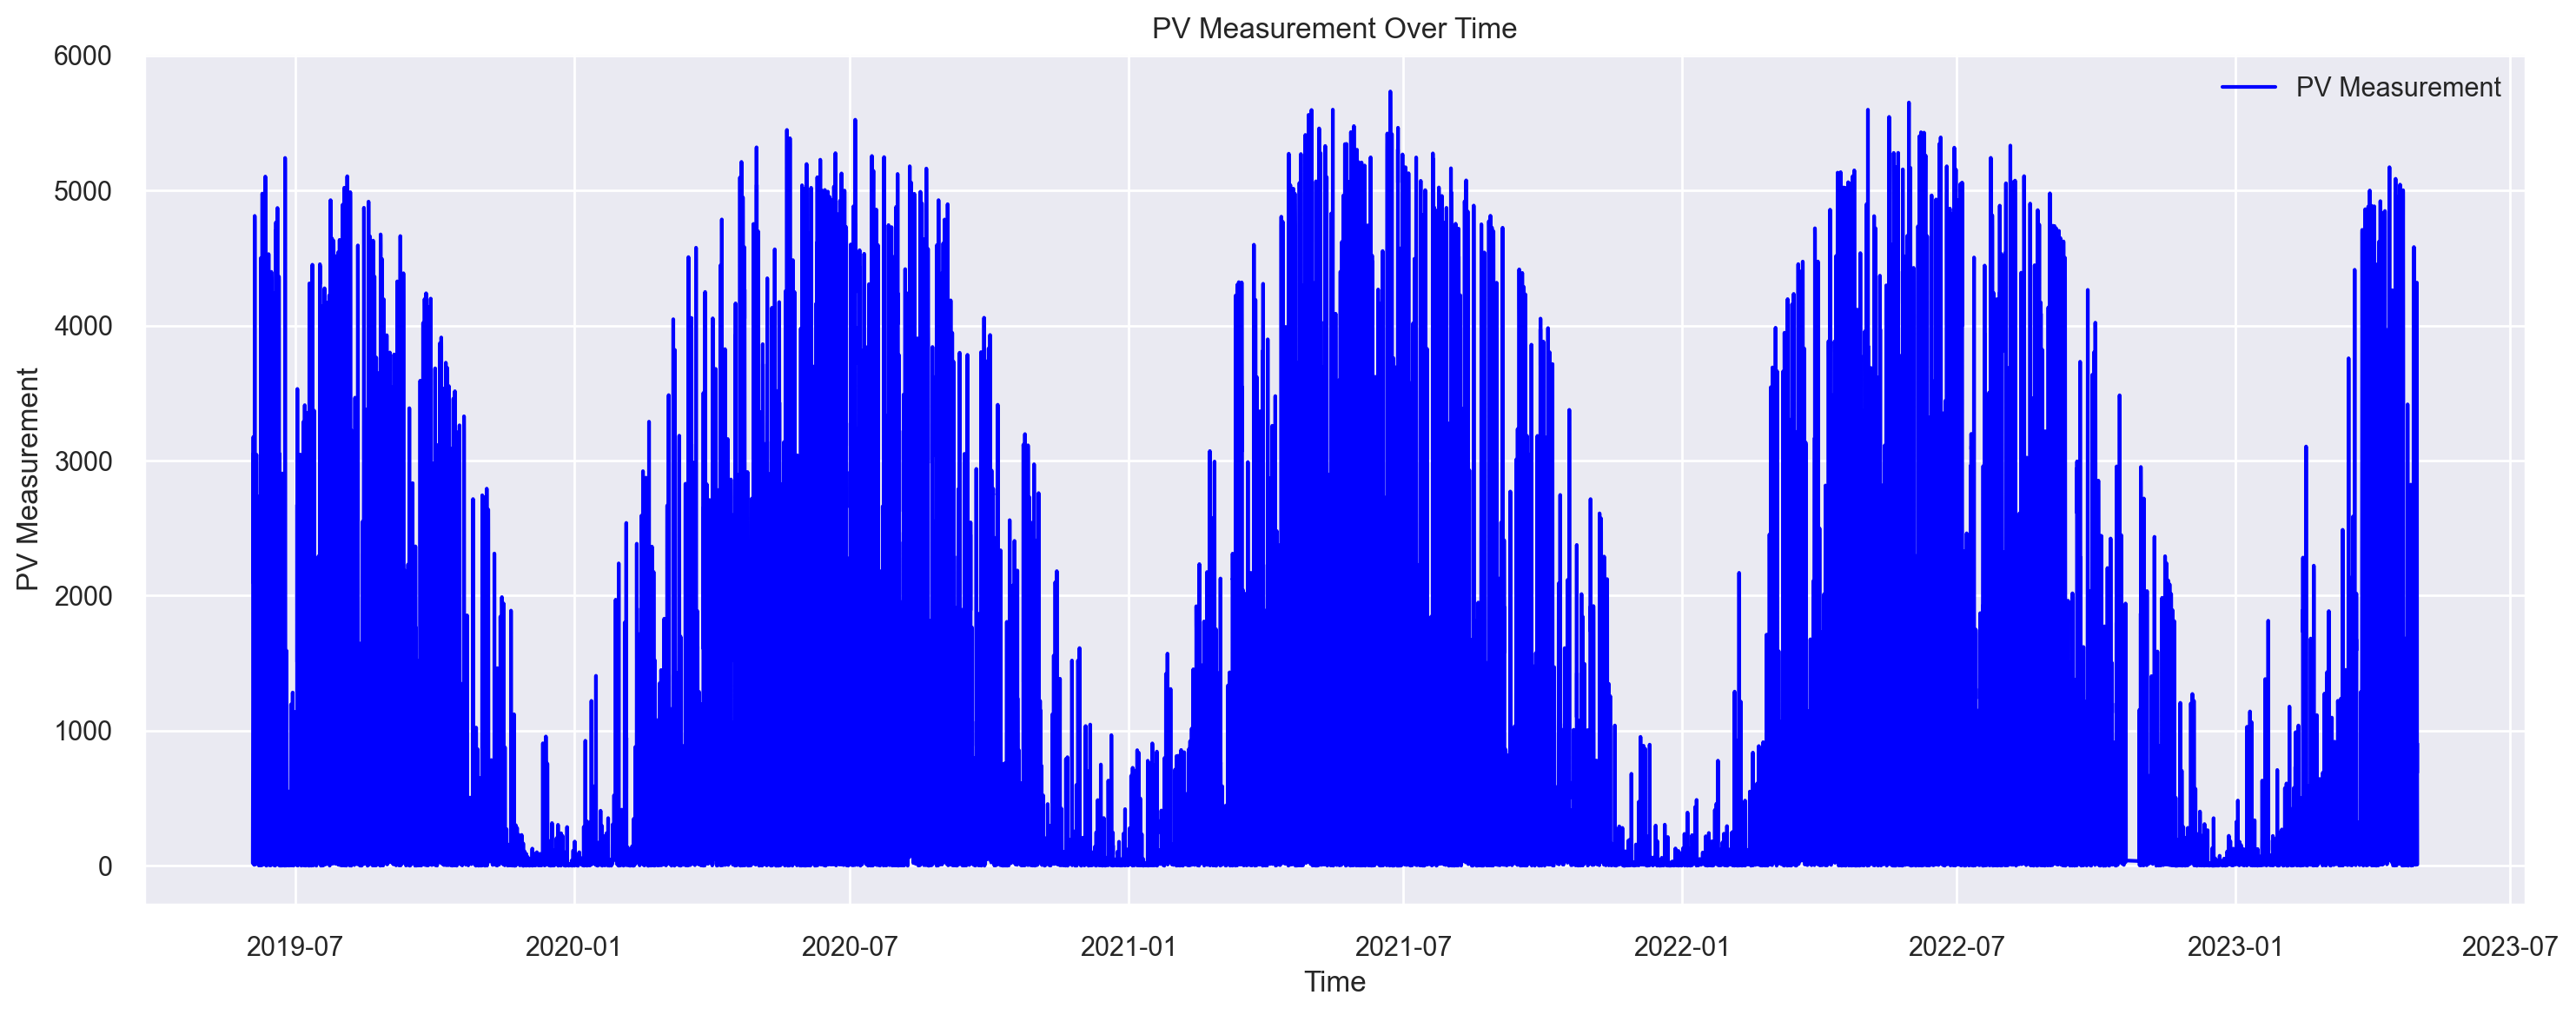

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are n

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Regression
3,Original data shape,"(18036, 163)"
4,Transformed data shape,"(18036, 175)"
5,Transformed train set shape,"(12625, 175)"
6,Transformed test set shape,"(5411, 175)"
7,Ordinal features,1
8,Numeric features,159
9,Categorical features,3


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are n

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,327.9100,257299.8997,507.2474,0.8619,0.9488,5.8485
1,302.4502,237611.7129,487.4543,0.8683,0.8459,2.6624
2,313.5585,263289.2218,513.1172,0.8544,0.9177,3.4624
3,310.5577,250875.7149,500.8749,0.8608,0.8547,2.6485
4,343.8754,293471.4216,541.7300,0.8431,0.8889,2.9109
5,336.5667,291336.8281,539.7563,0.8482,0.8736,3.5203
6,303.1430,248692.0926,498.6904,0.8667,0.9152,3.2992
7,327.1078,283065.5222,532.0390,0.8621,0.8790,2.5004
8,317.9050,267997.3314,517.6846,0.8549,0.9021,2.8853


CatBoost Done
#############################################
Running LightGBM


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,328.0474,258456.9904,508.3867,0.8613,0.8701,3.8416
1,307.6372,247421.6678,497.4150,0.8628,0.8203,2.4622
2,316.8286,274186.6258,523.6283,0.8483,0.8794,3.2376
3,313.2520,256737.6538,506.6929,0.8575,0.8174,2.3817
4,336.3559,283799.7673,532.7286,0.8482,0.8393,2.5172
5,334.5008,292138.3234,540.4982,0.8478,0.8468,2.5025
6,311.7447,256083.5657,506.0470,0.8627,0.8729,3.0407
7,327.7480,282606.1146,531.6071,0.8624,0.7982,2.1997
8,323.4596,272727.4272,522.2331,0.8524,0.8621,2.5459


LightGBM Done
#############################################
Blending


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,321.7940,251032.1471,501.0311,0.8653,0.8390,3.8662
1,299.7714,236331.5181,486.1394,0.8690,0.7984,2.1935
2,308.9338,262116.6822,511.9733,0.8550,0.8578,2.9275
3,305.5415,247426.3974,497.4197,0.8627,0.7926,1.9532
4,334.1347,282299.1916,531.3184,0.8490,0.8164,2.2151
5,330.6177,284545.6938,533.4282,0.8517,0.7952,2.4321
6,301.5926,246441.7448,496.4290,0.8679,0.8664,2.8557
7,322.8476,276980.5666,526.2894,0.8651,0.8004,2.1000
8,314.3287,263453.7591,513.2775,0.8574,0.8354,2.4286


Blended
#############################################
Finalizing
Finalized
#############################################


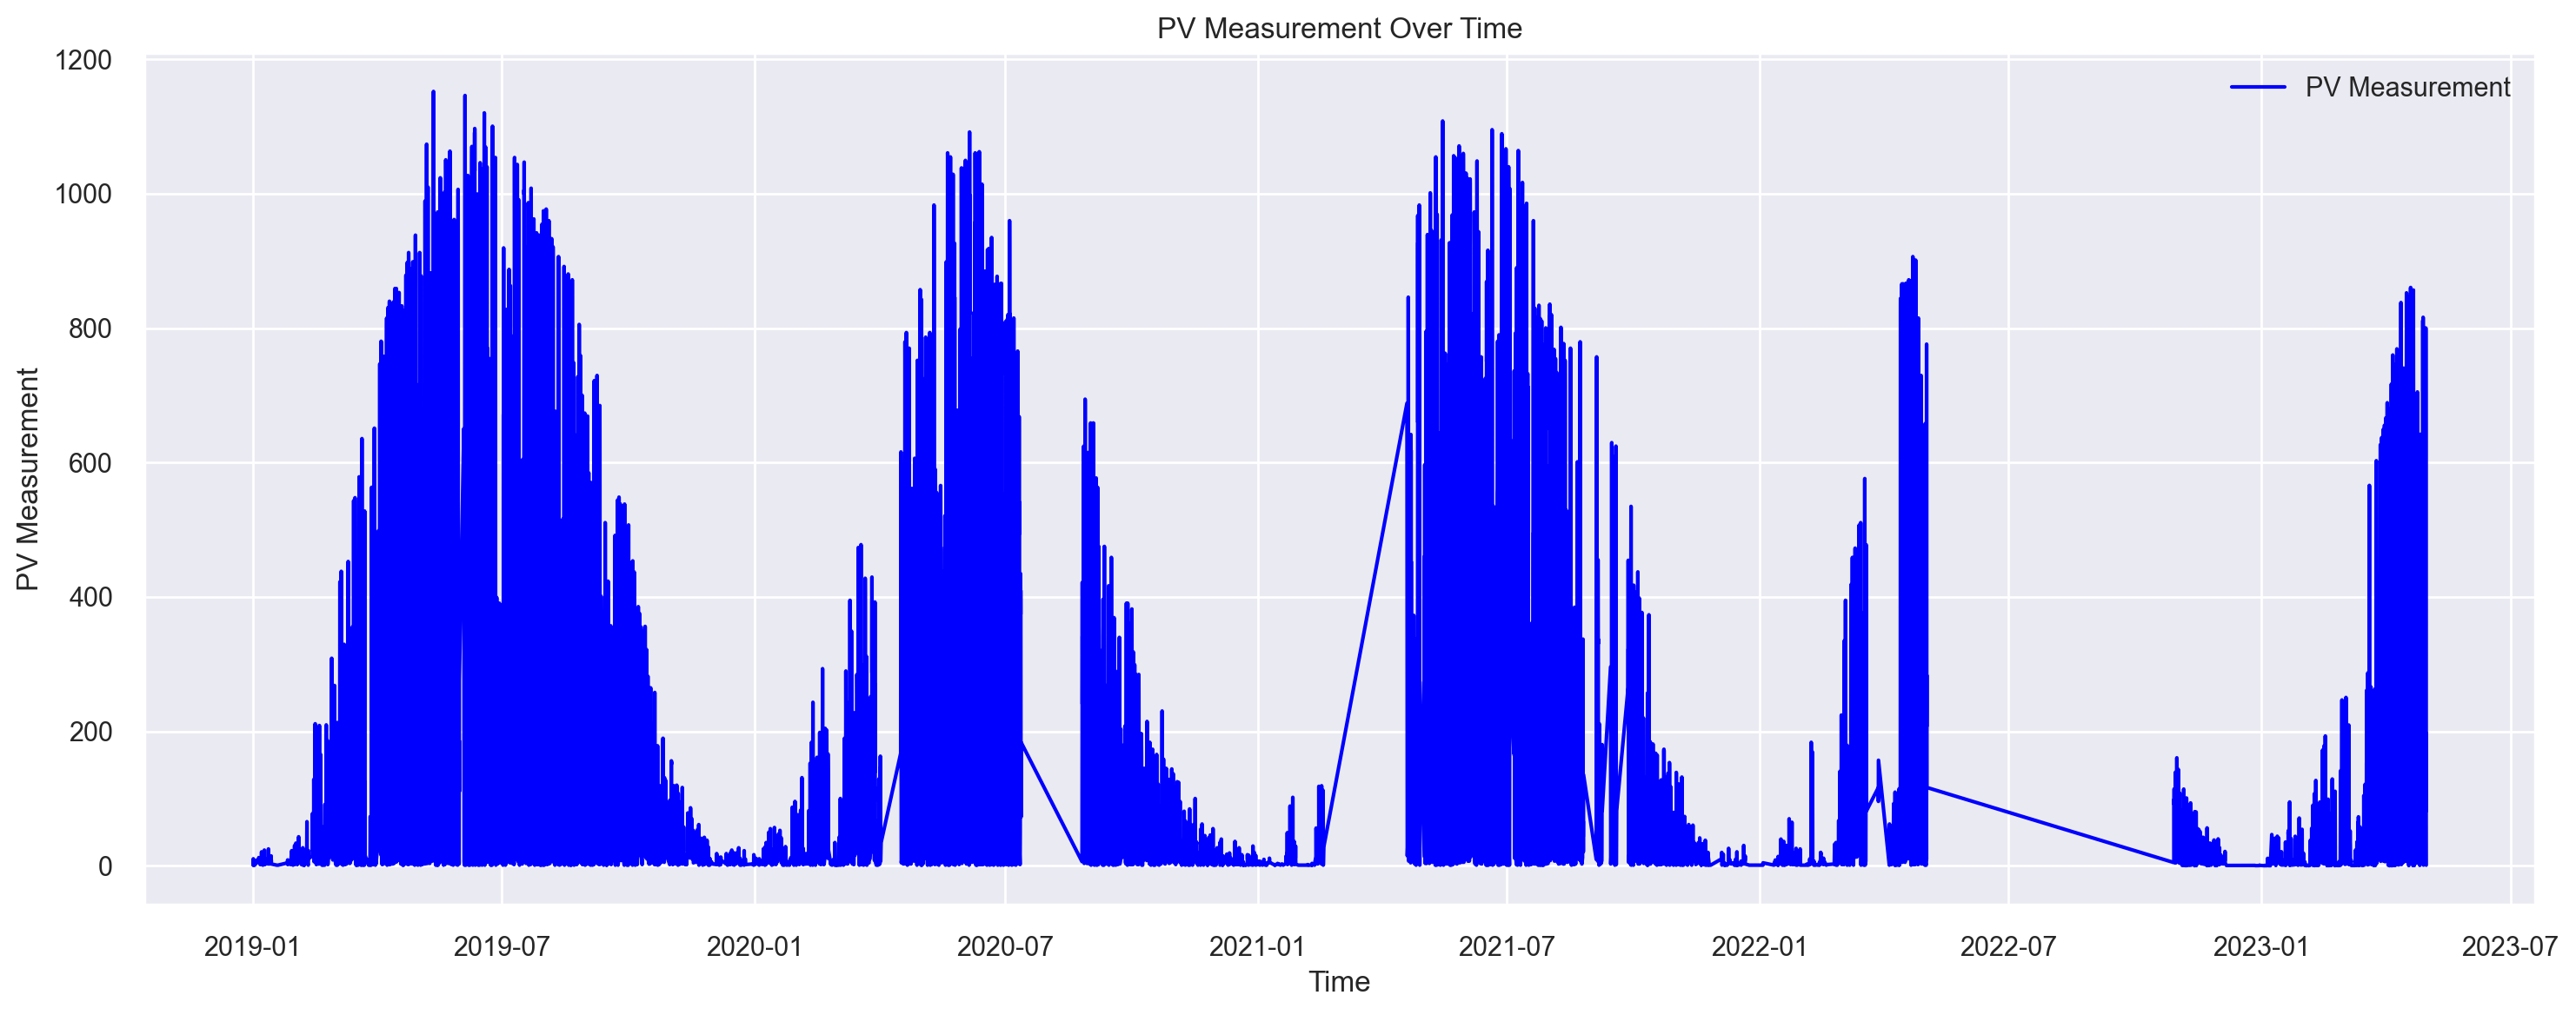

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are n

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Regression
3,Original data shape,"(12274, 163)"
4,Transformed data shape,"(12274, 174)"
5,Transformed train set shape,"(8591, 174)"
6,Transformed test set shape,"(3683, 174)"
7,Ordinal features,1
8,Numeric features,159
9,Categorical features,3


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are n

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,50.8166,6994.0974,83.6307,0.9022,0.7151,1.8665
1,52.0237,7577.0108,87.0460,0.8901,0.6584,1.2506
2,50.9572,7194.9653,84.8231,0.8907,0.7294,1.9245
3,49.1602,6517.8682,80.7333,0.9019,0.6815,1.2707
4,50.5661,6536.8621,80.8509,0.9054,0.7128,1.4713
5,50.7049,6845.2831,82.7362,0.8952,0.7910,1.8006
6,52.1274,7185.5964,84.7679,0.8959,0.7432,1.4819
7,51.5600,6860.2682,82.8267,0.9024,0.7819,2.0555
8,57.2094,10035.8733,100.1792,0.8670,0.7395,84.1241


CatBoost Done
#############################################
Running LightGBM


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,51.6580,7216.4851,84.9499,0.8991,0.7102,1.6347
1,51.1813,7336.0780,85.6509,0.8936,0.6863,1.4001
2,50.8540,7280.9678,85.3286,0.8894,0.6788,1.4736
3,48.0780,6179.6538,78.6108,0.9070,0.6937,1.2450
4,49.2976,6286.0216,79.2844,0.9090,0.6930,1.5882
5,49.4938,6646.6676,81.5271,0.8982,0.7363,1.7799
6,52.1626,7354.6141,85.7590,0.8935,0.7497,1.6275
7,49.3668,6547.7965,80.9185,0.9069,0.7379,1.8185
8,56.8479,9489.8305,97.4158,0.8742,0.6981,49.0355


LightGBM Done
#############################################
Blending


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,50.4059,6935.3771,83.2789,0.9031,0.7070,1.5642
1,50.5263,7220.4224,84.9731,0.8952,0.6582,1.2883
2,49.6763,6953.6180,83.3884,0.8944,0.6825,1.5838
3,47.7475,6152.1917,78.4359,0.9074,0.6615,1.2005
4,48.8324,6238.9761,78.9872,0.9097,0.6857,1.4340
5,49.2907,6555.0250,80.9631,0.8996,0.7453,1.7333
6,51.2038,7064.8461,84.0526,0.8977,0.7271,1.5180
7,49.6706,6518.5507,80.7375,0.9073,0.7503,1.8915
8,55.9754,9551.0134,97.7293,0.8734,0.6977,66.5334


Blended
#############################################
Finalizing
Finalized
#############################################


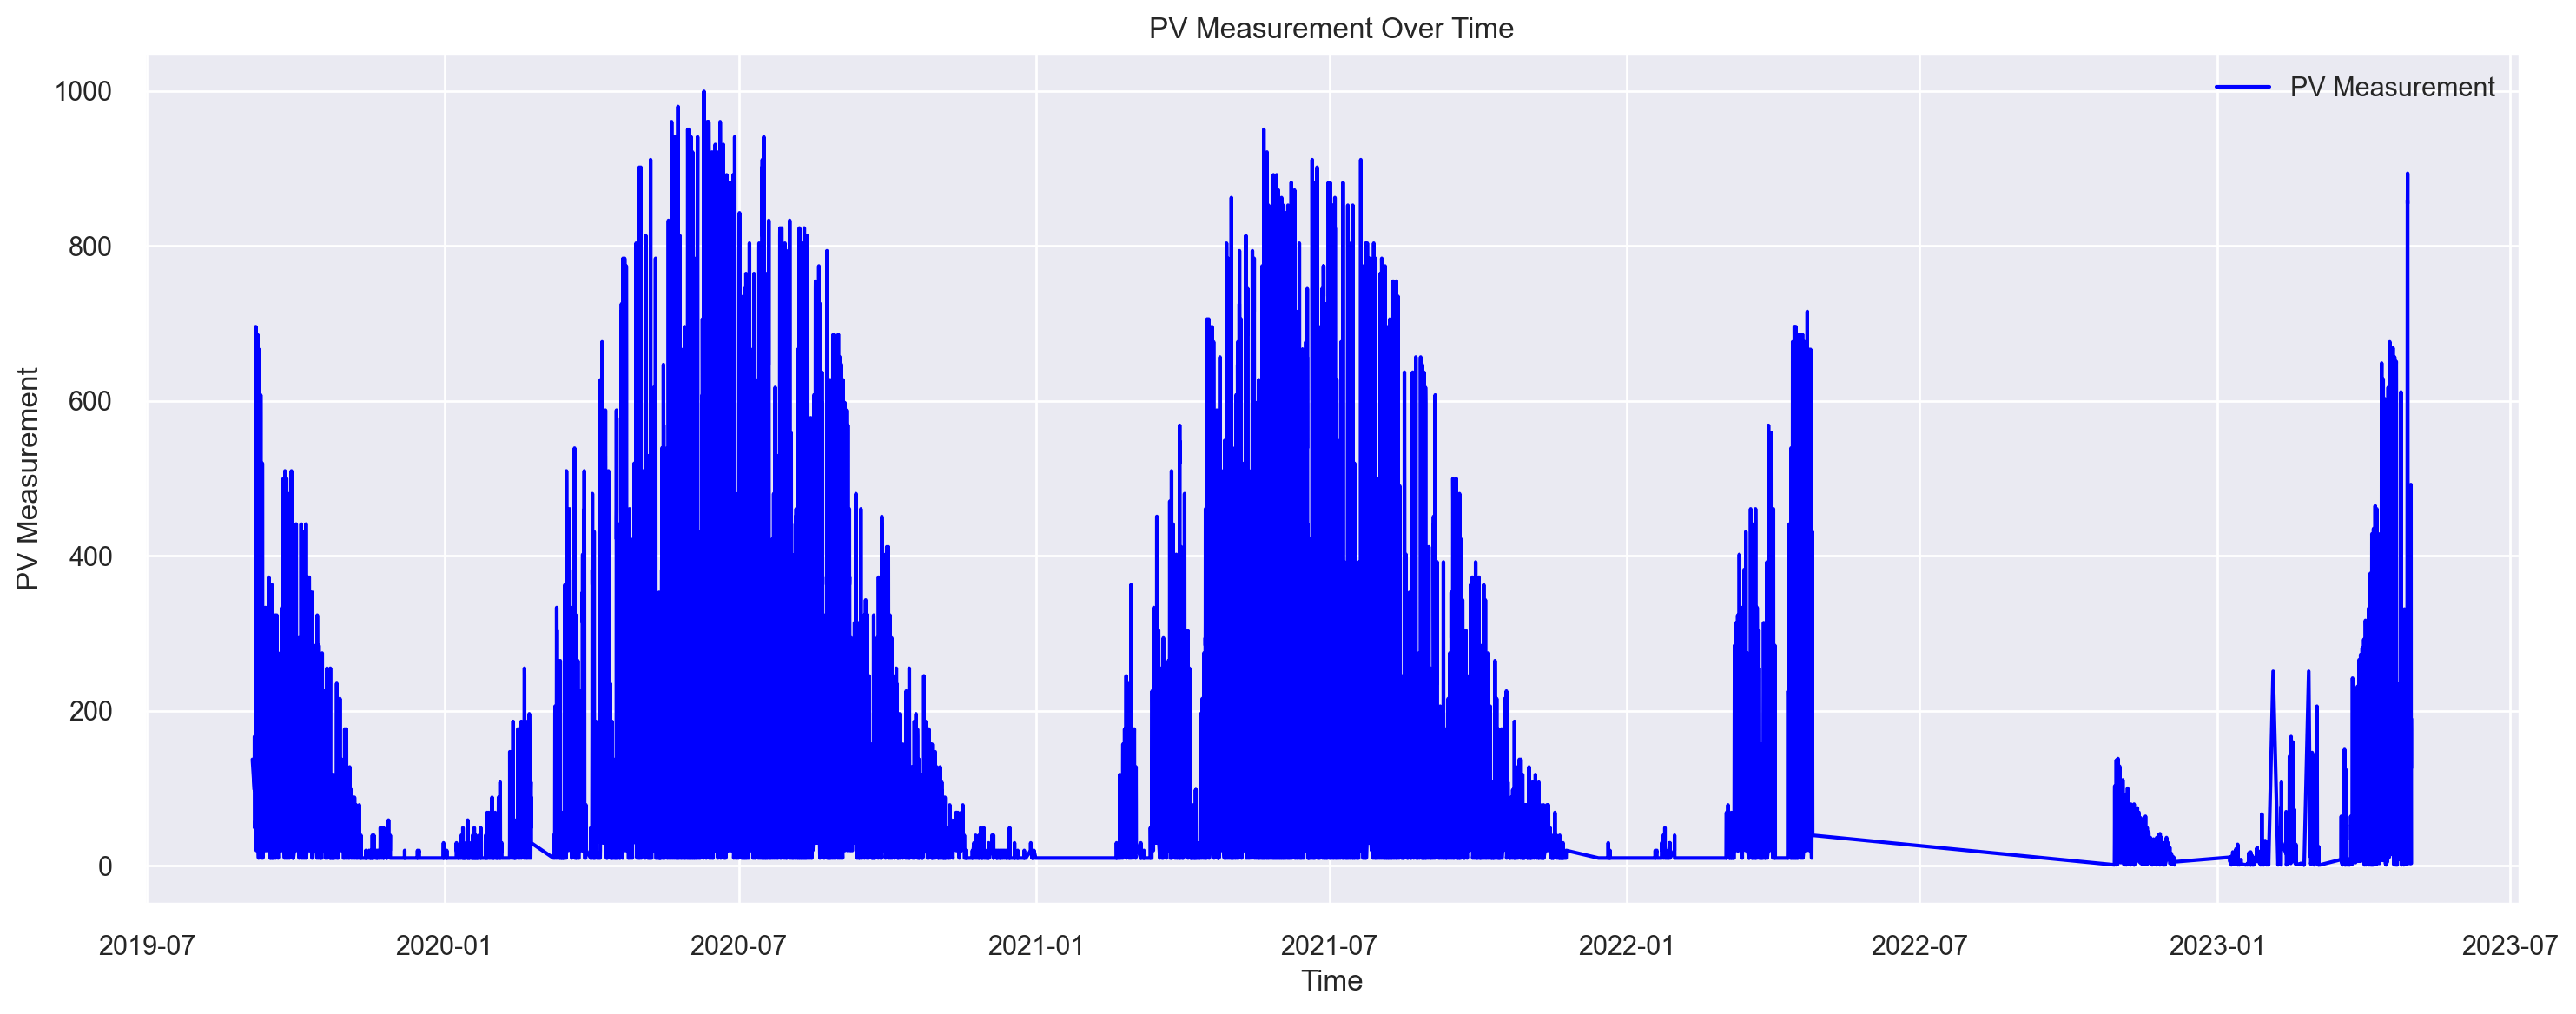

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are n

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Regression
3,Original data shape,"(9676, 163)"
4,Transformed data shape,"(9676, 175)"
5,Transformed train set shape,"(6773, 175)"
6,Transformed test set shape,"(2903, 175)"
7,Ordinal features,1
8,Numeric features,159
9,Categorical features,3


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are n

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,44.8851,5355.2944,73.1799,0.8822,0.5355,0.6003
1,41.6326,4703.3004,68.5806,0.9056,0.5111,0.5854
2,43.1209,5000.6281,70.7151,0.8990,0.4839,0.4774
3,48.5382,6076.0073,77.9487,0.8562,0.5439,0.6652
4,43.2640,4861.4243,69.7239,0.9045,0.4974,0.5461
5,45.6049,5299.4752,72.7975,0.8874,0.4913,0.5110
6,46.7648,5943.5024,77.0941,0.8592,0.5325,0.5723
7,44.0610,4960.8802,70.4335,0.8825,0.5990,0.8256
8,44.7369,5176.3872,71.9471,0.8902,0.5395,0.6613


CatBoost Done
#############################################
Running LightGBM


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,44.0003,5349.6976,73.1416,0.8823,0.5490,0.6593
1,43.1437,5020.5856,70.8561,0.8992,0.5278,0.5669
2,42.7515,5123.1217,71.5760,0.8965,0.4717,0.5085
3,49.5648,6048.8044,77.7741,0.8568,0.5794,0.7428
4,43.1220,4819.5787,69.4232,0.9053,0.5139,0.6400
5,44.2556,4959.0421,70.4205,0.8947,0.4920,0.5760
6,45.9090,5618.5049,74.9567,0.8669,0.4847,0.5405
7,44.5491,5246.4742,72.4325,0.8757,0.6139,0.9693
8,44.3214,4982.3029,70.5854,0.8944,0.5383,0.6750


LightGBM Done
#############################################
Blending


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,43.6907,5198.8357,72.1030,0.8856,0.5258,0.6095
1,41.5626,4694.2020,68.5142,0.9058,0.5000,0.5624
2,42.1217,4924.7501,70.1766,0.9005,0.4535,0.4782
3,48.2439,5870.2852,76.6178,0.8610,0.5442,0.6611
4,42.3144,4684.6046,68.4442,0.9080,0.4905,0.5741
5,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000
6,45.6743,5648.8864,75.1591,0.8661,0.4969,0.5435
7,43.5729,4957.9498,70.4127,0.8825,0.5928,0.8855
8,43.9122,4938.4487,70.2741,0.8953,0.5235,0.6576


Blended
#############################################
Finalizing
Finalized
#############################################


In [ ]:
locations = ['A', 'B', 'C']

for i in range(10):
    all_predictions = []
    final_df_list = [] 
    for loc in locations:
        # Load your data
        train = pd.read_parquet(f'Data/{loc}/train_targets.parquet').fillna(0)
        X_train_estimated = pd.read_parquet(f'Data/{loc}/X_train_estimated.parquet')
        X_train_observed = pd.read_parquet(f'Data/{loc}/X_train_observed.parquet')
        X_test_estimated = pd.read_parquet(f'Data/{loc}/X_test_estimated.parquet')

        #lage dag og måned feature der man aggregerer opp 
        # Preprocess data
        X_train, X_test, is_day_feature, targets = preprocessing(train, X_train_observed, X_train_estimated, X_test_estimated)
        y_train = targets

        # Ensure X and y have the same length
        min_length = min(len(X_train), len(y_train))
        X_train, y_train = X_train.iloc[:min_length], y_train[:min_length]


        data = X_train.copy()
        data.columns = data.columns.str.replace('[^\w\s]', '')

        X_test.columns = X_test.columns.str.replace('[^\w\s]', '')

        data['target'] = y_train['pv_measurement']

        exp_reg = RegressionExperiment()
        exp_reg.setup(
            data = data,
            target = 'target', 
            session_id = 123,
            categorical_features = ['dew_or_rimeidx', 'is_in_shadowidx', 'is_estimated'],
            # html = False,
            experiment_name = f'exp_{loc}', 
            use_gpu = True,
            # verbose = False
        )
        
        # Process the location data and get the final model
        print("#############################################")
        print("Running CatBoost")
        model_catboost = exp_reg.create_model('catboost')
        print("CatBoost Done")
        print("#############################################")
        print("Running LightGBM")
        model_lightgbm = exp_reg.create_model('lightgbm')
        print("LightGBM Done")
        print("#############################################")
        print("Blending")
        blended_models = exp_reg.blend_models([model_catboost, model_lightgbm])
        print("Blended")
        print("#############################################")
        # Finalize the model
        print("Finalizing")
        blended_models = exp_reg.finalize_model(blended_models)
        print("Finalized")
        print("#############################################")
        # Predict on new data
        predictions = exp_reg.predict_model(blended_models, data=X_test)
        final_predictions = (predictions['prediction_label'])
        
        # Multiply final predictions with the 'is_day:idx' values do remove night time predictions
        adjusted_final_predictions = final_predictions * is_day_feature['is_day:idx']
        adjusted_final_predictions = np.clip(adjusted_final_predictions, 0, None)
        # Now, 'adjusted_final_predictions' contains the adjusted target values.

        # Store predictions
        all_predictions.append(adjusted_final_predictions) 
    
    def save_predictions(all_predictions, title):
        final_predictions = np.concatenate(all_predictions)
        df = pd.DataFrame(final_predictions, columns=['prediction'])
        df['id'] = df.index
        df = df[['id', 'prediction']]
        df.to_csv(f"{title}", index=False)

    title = f'run_{i+1}_short_notebook_2.csv'
    save_predictions(all_predictions, title)

## Taking the mean

In [ ]:
avg = np.zeros(720*3)
for i in range(10):
    j = i+1
    avg += pd.read_csv(f"run_{j}_short_notebook_2.csv")["prediction"]
avg = avg/j

df = pd.DataFrame(avg, columns=['prediction'])
df['id'] = df.index
df = df[['id', 'prediction']]
df.to_csv(f"run_mean(final_prediction).csv", index=False)